# The Blood Transfusion Service Center Dataset

### Introduction 
Blood donation has been around for a long time. The first successful recorded transfusion was between two dogs in 1665, and the first medical use of human blood in a transfusion occurred in 1818. Even today, donated blood remains a critical resource during emergencies.

Our dataset is from a mobile blood donation vehicle in Taiwan. The Blood Transfusion Service Center drives to different universities and collects blood as part of a blood drive. 

### Problem Statement
We want to predict whether or not a donor will give blood the next time the vehicle comes to campus.

### Approach
As we are asked to provide the probability that a particular donor will donate blood (a binary variable), we use 3 different types of classification models - Logistic Regression, Random Forest and Gradient Boosting (AdaBoost).

To decide on which model to use for the prediction of the test dataset, we use the logistic loss, or cross-entropy loss as our evaluation metric.

### Result
It turns out that the logistic model scored the best using the entropy loss metric. Using the simple logistic model, our entropy loss on the test dataset was 0.4458. This score was good enough to place us at rank 383 out of 2992 competitors (top 13th percentile) - 16 Jul.

## Importing key libraries and reading dataframes

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_train = pd.read_csv('Warm_Up_Predict_Blood_Donations_-_Traning_Data.csv')
df_test = pd.read_csv('Warm_Up_Predict_Blood_Donations_-_Test_Data.csv')

## Splitting into training and cross validation dataset

In [3]:
print(df_train.shape)
df_train.head()

(576, 6)


,Unnamed: 0,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
0,619,2,50,12500,98,1
1,664,0,13,3250,28,1
2,441,1,16,4000,35,1
3,160,2,20,5000,45,1
4,358,1,24,6000,77,0


It appears that the first column is the ID number. As the ID number doesn't contain any valuable information, we filter it out for our analysis.

In [4]:
from sklearn.model_selection import train_test_split

X = df_train.ix[:, 1:5]
y = df_train[['Made Donation in March 2007']]

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [5]:
df_test.head()

,Unnamed: 0,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation
0,659,2,12,3000,52
1,276,21,7,1750,38
2,263,4,1,250,4
3,303,11,11,2750,38
4,83,4,12,3000,34


In [6]:
X_test = df_test.ix[:, 1:5]

In [7]:
X_train = X_train.reset_index(drop = True)
X_cv = X_cv.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

## Exploratory Data Analysis

We first check for any missing values in the training and testing data.

In [8]:
X_train.isnull().sum()

Months since Last Donation     0
Number of Donations            0
Total Volume Donated (c.c.)    0
Months since First Donation    0
dtype: int64

In [9]:
X_cv.isnull().sum()

Months since Last Donation     0
Number of Donations            0
Total Volume Donated (c.c.)    0
Months since First Donation    0
dtype: int64

In [10]:
X_test.isnull().sum()

Months since Last Donation     0
Number of Donations            0
Total Volume Donated (c.c.)    0
Months since First Donation    0
dtype: int64

It turns out that the training, cross validation and testing dataset do not contain any NA values at all! That makes our data cleaning process much easier.

We can now plot the distribution of the 4 different columns in the training data to get an idea of what we are dealing with.

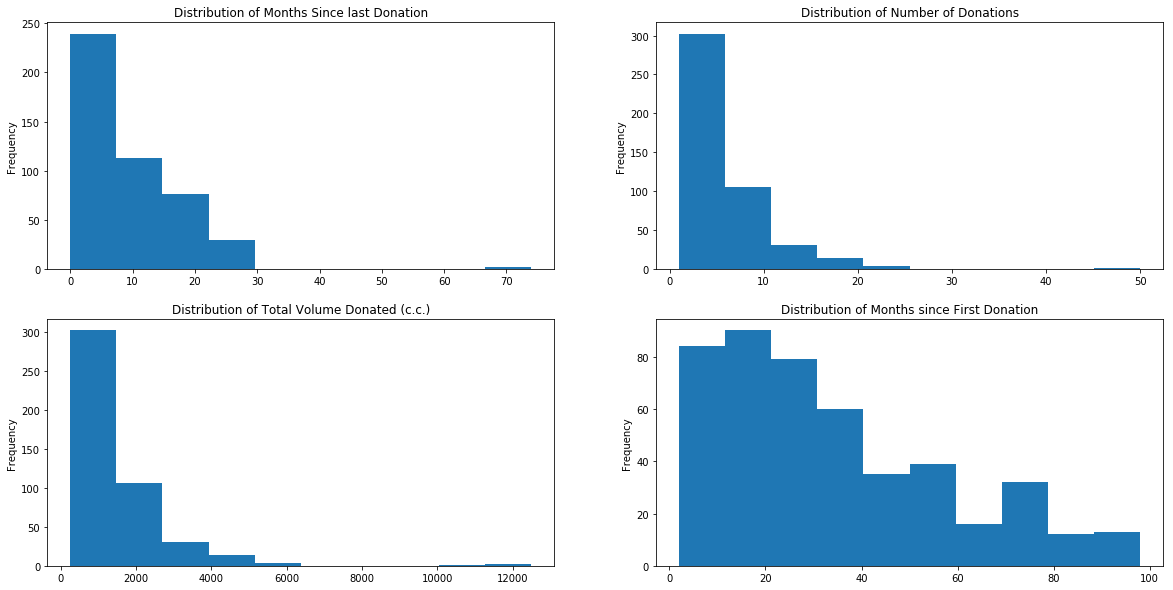

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20, 10))
plt.subplot(2, 2, 1)
plt.hist(X_train['Months since Last Donation'])
plt.ylabel('Frequency')
plt.title('Distribution of Months Since last Donation')

plt.subplot(2, 2, 2)
plt.hist(X_train['Number of Donations'])
plt.ylabel('Frequency')
plt.title('Distribution of Number of Donations')

plt.subplot(2, 2, 3)
plt.hist(X_train['Total Volume Donated (c.c.)'])
plt.ylabel('Frequency')
plt.title('Distribution of Total Volume Donated (c.c.)')

plt.subplot(2, 2, 4)
plt.hist(X_train['Months since First Donation'])
plt.ylabel('Frequency')
plt.title('Distribution of Months since First Donation')
plt.show()

Just by looking at the histograms of the various features, there appears to be some outliers.

We proceed to examine the relationship across the 4 features in the training dataset, by means of a pairsplot.

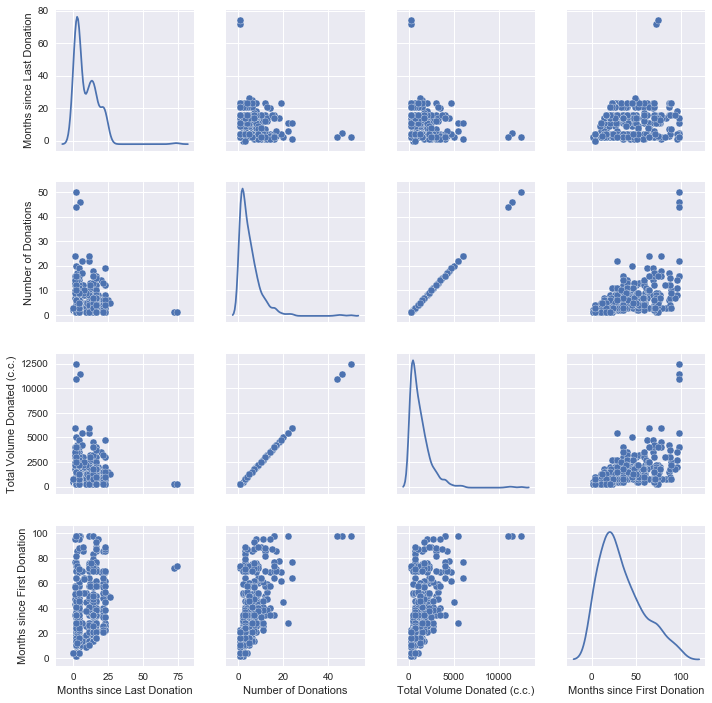

In [12]:
import seaborn as sns

sns.pairplot(X_train, diag_kind='kde')
plt.show()

Both the feature distribution plots and the pairsplot seem to suggest that there are a few anomalies in the dataset. In addition, the pairsplot seem to suggest a linear relationship between the variables, Total Number of Donations and Total Volume Donated. Could they be perfectly correlated?

We check for the correlation between these features, by means of a heatmap.

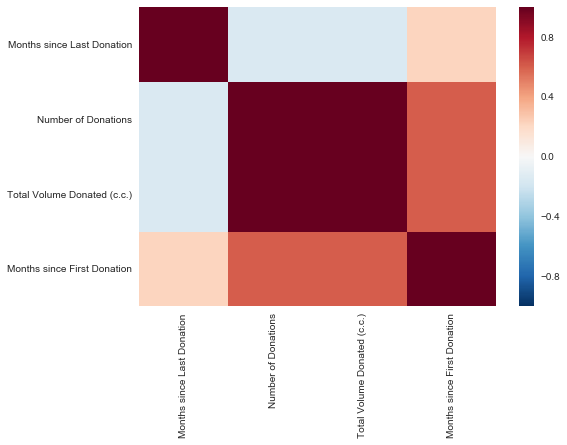

In [13]:
X_train_corr = X_train.corr()

sns.heatmap(X_train_corr)
plt.show()

This confirms our suspicion that the features, Number of Donations and Total Volume Donated, are indeed perfectly correlated. 

In addition, we note that that there is a weak positive correlation between Number of Donations (same for Total Volume Donated) and Months since First Donation. This is likely due to the presence of anomalies present in our training dataset.

Lastly, we take a quick look at the unique values that the label can take on.

In [14]:
print set(y_train['Made Donation in March 2007'])
print set(y_cv['Made Donation in March 2007'])

set([0, 1])
set([0, 1])


This suggests that we do not have to conduct data cleaning for the label variable.

### Feature Engineering and Feature Selection

As some of our features are perfectly correlated with one another, including all these features do not provide any additional information as compared to only including 1 of these features. This means that we should remove one of the features which are perfectly correlated with the other feature.

But before we do so, we could generate additional features using existing ones. One feature we may be interested in is long each each individual takes to donate blood, on average.

In [15]:
X_train['Waiting_Length'] = (X_train['Months since First Donation']-X_train['Months since Last Donation'])/(X_train['Number of Donations'])

In [16]:
X_train.head()

,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Waiting_Length
0,4,4,1000,18,3.50
1,2,1,250,2,0.00
2,20,14,3500,69,3.50
3,2,2,500,11,4.50
4,11,4,1000,58,11.75


We do the same for the cross validation dataset and the testing dataset.

In [17]:
X_cv['Waiting_Length'] = (X_cv['Months since First Donation']-X_cv['Months since Last Donation'])/(X_cv['Number of Donations'])
X_test['Waiting_Length'] = (X_test['Months since First Donation']-X_test['Months since Last Donation'])/(X_test['Number of Donations'])

Next, we proceed to remove the Total Volume Donated (c.c.) feature from the 3 datasets.

In [18]:
cols_to_keep = ['Months since Last Donation', 'Number of Donations',
                'Months since First Donation', 'Waiting_Length']
X_train = X_train[cols_to_keep]; X_cv = X_cv[cols_to_keep]; X_test = X_test[cols_to_keep]

In [19]:
X_train.head()

,Months since Last Donation,Number of Donations,Months since First Donation,Waiting_Length
0,4,4,18,3.50
1,2,1,2,0.00
2,20,14,69,3.50
3,2,2,11,4.50
4,11,4,58,11.75


Finally, we plot the distribution of our last parameter, Waiting Length for Donation (by Months).

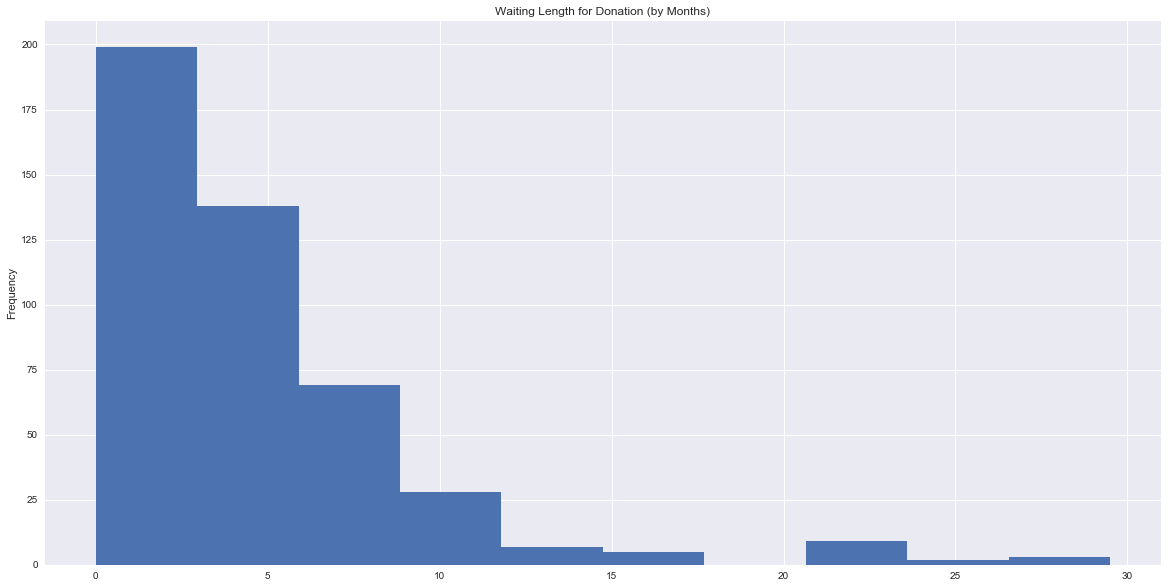

In [20]:
plt.figure(figsize = (20, 10))
plt.hist(X_train['Waiting_Length'])
plt.ylabel('Frequency')
plt.title('Waiting Length for Donation (by Months)')
plt.show()

From the graph, it appears that there are many frequent blood donors (waiting length between 0 and 5 months).

Lastly, we create new polynomial features between the existing features by calling the function:
```python
from sklearn.preprocessing import PolynomialFeatures
```

In [21]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

X_train_2 = poly.fit_transform(X_train)
X_cv_2 = poly.transform(X_cv)
X_test_2 = poly.transform(X_test)

### Model Fitting

Noting that we are asked to predict the probability of the donor donating blood, we fit 3 different kinds of models - Logistic Regression, Random Forest and Gradient Boosting (AdaBoost).

We can import these models from the scikit-learn library, using the following code: 
```python
from sklearn.linear_model import LogisticRegressionCV # Logistic Regression
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.ensemble import AdaBoostClassifier # Gradient Boosting (AdaBoost)
from sklearn.neural_network import MLPClassifier # Neural Network
``` 

In addition, we conduct hyperparameter and optimizer tuning to search for the best models across each class. We can implement this using:
```python
from sklearn.model_selection import GridSearchCV
```

But before we fit these models, we conduct feature normalization on our dataset.

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_2)
X_cv_scaled = scaler.transform(X_cv_2)
X_test_scaled = scaler.transform(X_test_2)

Next, we can fit the 3 different kinds of models.

In [23]:
# Model 1 - Logistic Regression
from sklearn.linear_model import LogisticRegressionCV

logregr = LogisticRegressionCV(cv = 10, random_state=12, scoring ='neg_log_loss')
logregr = logregr.fit(X_train_scaled, y_train['Made Donation in March 2007'])

y_cv_logregr = logregr.predict_proba(X_cv_scaled)[:, 1]

In [24]:
# Model 2 - RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

randomforest = RandomForestClassifier()
param_grid = {'n_estimators': [10, 20, 30],
              'max_features': [1, 2, 3],
              'random_state': [10]}
rf = GridSearchCV(estimator = randomforest, param_grid = param_grid, scoring = 'neg_log_loss')
rf.fit(X_train_scaled, y_train['Made Donation in March 2007'])

y_cv_rf = rf.predict_proba(X_cv_scaled)[:, 1]

In [25]:
# Model 3 - AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

abc = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 1))
param_grid = {'n_estimators': [10, 20, 30],
              'algorithm': ['SAMME', 'SAMME.R'],
              'random_state': [10]}
abc = GridSearchCV(abc, param_grid = param_grid, scoring = 'neg_log_loss')

abc.fit(X_train_scaled, y_train['Made Donation in March 2007'])

y_cv_abc = abc.predict_proba(X_cv_scaled)[:, 1]

We use the evaluation metric, entropy loss (or logistic loss) as our evaluation metric. To import this in python, we can do the following:
```python
from sklearn.metrics import log_loss
```

In [26]:
from sklearn.metrics import log_loss

# Logistic Regression
print 'Logistic Regression Entropy Loss: ', log_loss(y_cv, y_cv_logregr)

# Random Forest
print 'Random Forest Entropy Loss: ', log_loss(y_cv, y_cv_rf)

# AdaBoost
print 'Gradient Boosting Entropy Loss: ', log_loss(y_cv, y_cv_abc)

Logistic Regression Entropy Loss:  0.524012264492
Random Forest Entropy Loss:  1.9683143982
Gradient Boosting Entropy Loss:  0.625147706393


As it turns out, the Logistic Regression has the lowest entropy loss. We use the simple logistic model to conduct predictions for our test set.

### Prediction

In [27]:
y_test = pd.DataFrame(logregr.predict_proba(X_test_scaled)[:, 1])
y_test.columns = y_cv.columns; y_test.index = df_test['Unnamed: 0'].ravel()

y_test.head()

,Made Donation in March 2007
659,0.497328
276,0.107505
263,0.187261
303,0.324744
83,0.539564


In [28]:
y_test.to_csv('test_submission.csv')

Afternote: 

Using the simple logistic model, our entropy loss on the test was 0.4458. This score was good enough to place us at rank 383 out of 2982 competitors (top 13th percentile).